# Sharpe Style Analysis of Fund Returns

*by Chee-Foong on 3 Dec 2020*  

---

## Summary
This analysis explores **Sharpe Style Analysis** in which we will determine the fund's exposures to changes in the returns of major industry factors.

### Sharpe Style Analysis

Sharpe Style Analysis is an elegant and simple decomposition exercise similar to the factor analysis done using regression, with the added constraint that the coefficients are all positive and add to 1.

Therefore, the coefficients of performing style analysis on the observed return of a manager can be interpreted as weights in a portfolio of building blocks which together, *mimic* that return series. The exercise can reveal drifts in a manager's style as well as provide insight into what the manager is likely doing to obtain the returns.

### Funds
- **IYW** iShares U.S. Technology ETF
- **IYH** iShares U.S. Healthcare ETF
- **IYR** iShares U.S. Real Estate ETF
- **IYC** iShares U.S. Consumer Services ETF
- **IXC** iShares Global Energy ETF
- **ARKK** ARK INNOVATION ETF

### Industries
- Industry returns are downloaded from [Kenneth R. French - Data Library - Tuck](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html).  
- Their industry classification follows that of [SIC](https://www.sec.gov/info/edgar/siccodes.htm).

#### Definition for 10 Industry Portfolios
1. **NoDur** - Consumer Nondurables -- Food, Tobacco, Textiles, Apparel, Leather, Toys
2. **Durbl** - Consumer Durables -- Cars, TVs, Furniture, Household Appliances
3. **Manuf** - Manufacturing -- Machinery, Trucks, Planes, Chemicals, Off Furn, Paper, Com Printing
4. **Enrgy** - Oil, Gas, and Coal Extraction and Products
5. **HiTec** - Business Equipment -- Computers, Software, and Electronic Equipment
6. **Telcm** - Telephone and Television Transmission
7. **Shops** - Wholesale, Retail, and Some Services (Laundries, Repair Shops)
8. **Hlth** - Healthcare, Medical Equipment, and Drugs
9. **Utils** - Utilities
10. **Other** - Mines, Constr, BldMt, Trans, Hotels, Bus Serv, Entertainment, Finance


## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

import sys  
sys.path.append('../src') 
from edge_risk_kit import *

import edge_risk_kit as erk

In [2]:
import ipywidgets as widgets
from IPython.display import display

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

DATA_FOLDER = '../data/'

import urllib
import zipfile

In [4]:
def plot_pairs(data, columns):
    #scatterplot
    sns.set()
    sns.pairplot(data[columns], size = 2.5)
    plt.show()

## Download Fund Data

In [31]:
tickers = ['ARKK','IXC','IYC','IYH','IYW','IYR']

start_date = '1900-01-01'
end_date = '2020-12-31'

In [32]:
import yfinance as yf

tickerlist = {}
for ticker in tickers:
    tickerlist[ticker] = yf.Ticker(ticker).info['shortName']
    
data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  6 of 6 completed


In [33]:
prices = data['Adj Close'].dropna()

In [34]:
px_monthly = prices.resample('M').fillna('ffill')
px_monthly.index = px_monthly.index.to_period('M')
rets_monthly = px_monthly.pct_change().dropna()

In [35]:
def plot_perf(fund_name):
    fund_rets = rets_monthly[fund_name]

    dd_fund_rets = erk.drawdown(fund_rets)
    ax = dd_fund_rets["Wealth"].plot(figsize=(12,6), ls='-', color='goldenrod', linewidth=2)
    dd_fund_rets['Previous Peak'].plot(ax=ax, ls=':', color='blue')
    ax.set_title('{} Stock Performance'.format(fund_name))
    plt.show()

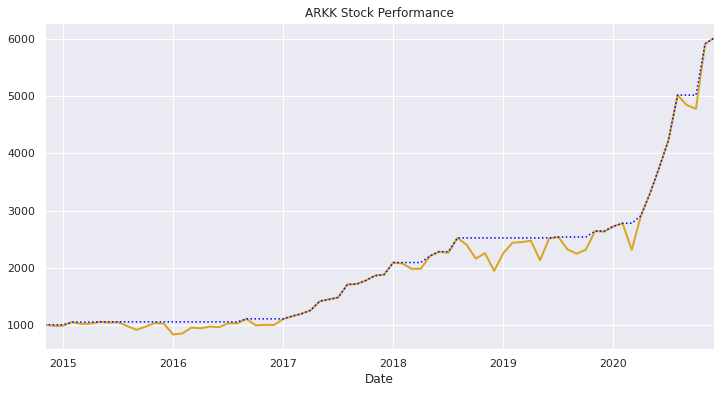

In [36]:
plot_perf('ARKK')

## Download Industry Returns

In [37]:
ind30_url = 'http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/30_Industry_Portfolios_CSV.zip'
ind10_url = 'http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/10_Industry_Portfolios_CSV.zip'

zip_path, _ = urllib.request.urlretrieve(ind30_url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(DATA_FOLDER)   

zip_path, _ = urllib.request.urlretrieve(ind10_url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(DATA_FOLDER)       

In [38]:
def process_ind_data(filename):
    ind_data = pd.read_csv(DATA_FOLDER + filename, skiprows=11)
    ind_data.rename(columns={ind_data.columns[0]:'date'}, inplace=True)
    ind_data[ind_data.date.isnull()]
    header_index = ind_data[ind_data.date.isnull()].index.to_list()
    header_index.append(ind_data.index[-1])
    header_index = [0] + header_index
    ind_data['type'] = np.nan
    tbl_name = ['vw_rets_mthly','ew_rets_mthly','vw_rets_annually','ew_rets_annually',
               'no_of_firms','avg_firm_size','be_over_me','vw_avg_beome']

    for i in range(0,len(tbl_name)):
        ind_data.loc[header_index[i]:header_index[i+1], 'type'] = tbl_name[i]

    ind_data.dropna(inplace=True)
    
    ind_data_vw_mthly = ind_data[ind_data.type == 'vw_rets_mthly']
    ind_data_vw_mthly.drop('type', axis=1, inplace=True)
    ind_data_vw_mthly.date = pd.to_datetime(ind_data_vw_mthly.date, format="%Y%m")
    ind_data_vw_mthly.set_index('date', inplace=True)
    ind_data_vw_mthly.index = ind_data_vw_mthly.index.to_period('M')
    ind_data_vw_mthly = ind_data_vw_mthly.astype(float)
    ind_data_vw_mthly = ind_data_vw_mthly.div(100)

    return ind_data_vw_mthly

In [39]:
ind_data_10 = process_ind_data('10_Industry_Portfolios.CSV')
ind_data_30 = process_ind_data('30_Industry_Portfolios.CSV')

In [40]:
rets_monthly[['IYW']]

,IYW
Date,
2014-11,0.051166
2014-12,-0.019307
2015-01,-0.038697
2015-02,0.083799
2015-03,-0.032477
...,...
2020-08,0.116170
2020-09,-0.055399
2020-10,-0.027668


### Performing Sharpe Style Analysis

The key to obtaining the weights is the quadriatic optimizer.  Objective is to find the weights that minimizes the square of the difference between the observed series and the returns of a benchmark portfolio that holds the explanatory building blocks in those same weights. This is equivalent to minimizing the *tracking error* between the two return series.

In [41]:
def rolling_style_ind(fund_name, window, industry=10):

    if industry == 10:
        ind_data = ind_data_10
    else:
        ind_data = ind_data_30
        
    data = pd.concat([rets_monthly[[fund_name]], ind_data], axis=1).dropna()
    dependent_variable = data.columns[0]
    independent_variables = data.columns[1:]
    
    results = []
    nrow, ncol = data.shape

    for i in range(window, nrow):
        coeff = {}
        subdata = data.iloc[i-window:i]
        result = erk.style_analysis(subdata.loc[:,dependent_variable], subdata.loc[:,independent_variables])
        for idx in result.index:
            coeff['date'] = subdata.index[-1]
            coeff[idx] = result[idx]
        results.append(coeff)
        
    return pd.DataFrame(results)

## Style Analysis on iShares U.S. Technology ETF

Observations:
1. As expected, the fund returns are almost all due to HiTec factor.
2. This is inline with the mandate of the ETF that to track an index composed of U.S. equities in the technology sector.
4. From the fund fact sheet, the fund has top sectors in Software and Services of 41.50%, follow by Tech Hardware & Equip of 24.84%.  

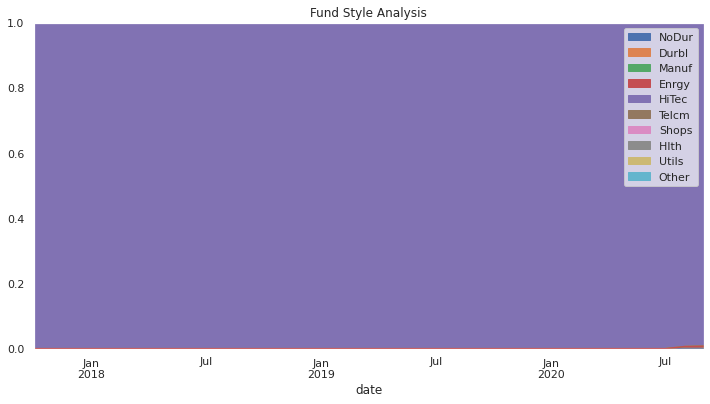

In [42]:
style_results = rolling_style_ind('IYW', 36, 10)
style_results.set_index('date', inplace=True)

# We need to transform the data from raw data to percentage (fraction)
style_results_perc = style_results.divide(style_results.sum(axis=1), axis=0)

style_results_perc.plot(kind='area', stacked=True, figsize=(12,6), title='Fund Style Analysis', ylim=(0,1))
plt.show()

In [43]:
style_results_perc.iloc[-1].round(2).sort_values(ascending=False)*100

HiTec    99.0
Durbl     1.0
Other     0.0
Utils     0.0
Hlth      0.0
Shops     0.0
Telcm     0.0
Enrgy     0.0
Manuf     0.0
NoDur     0.0
Name: 2020-09, dtype: float64

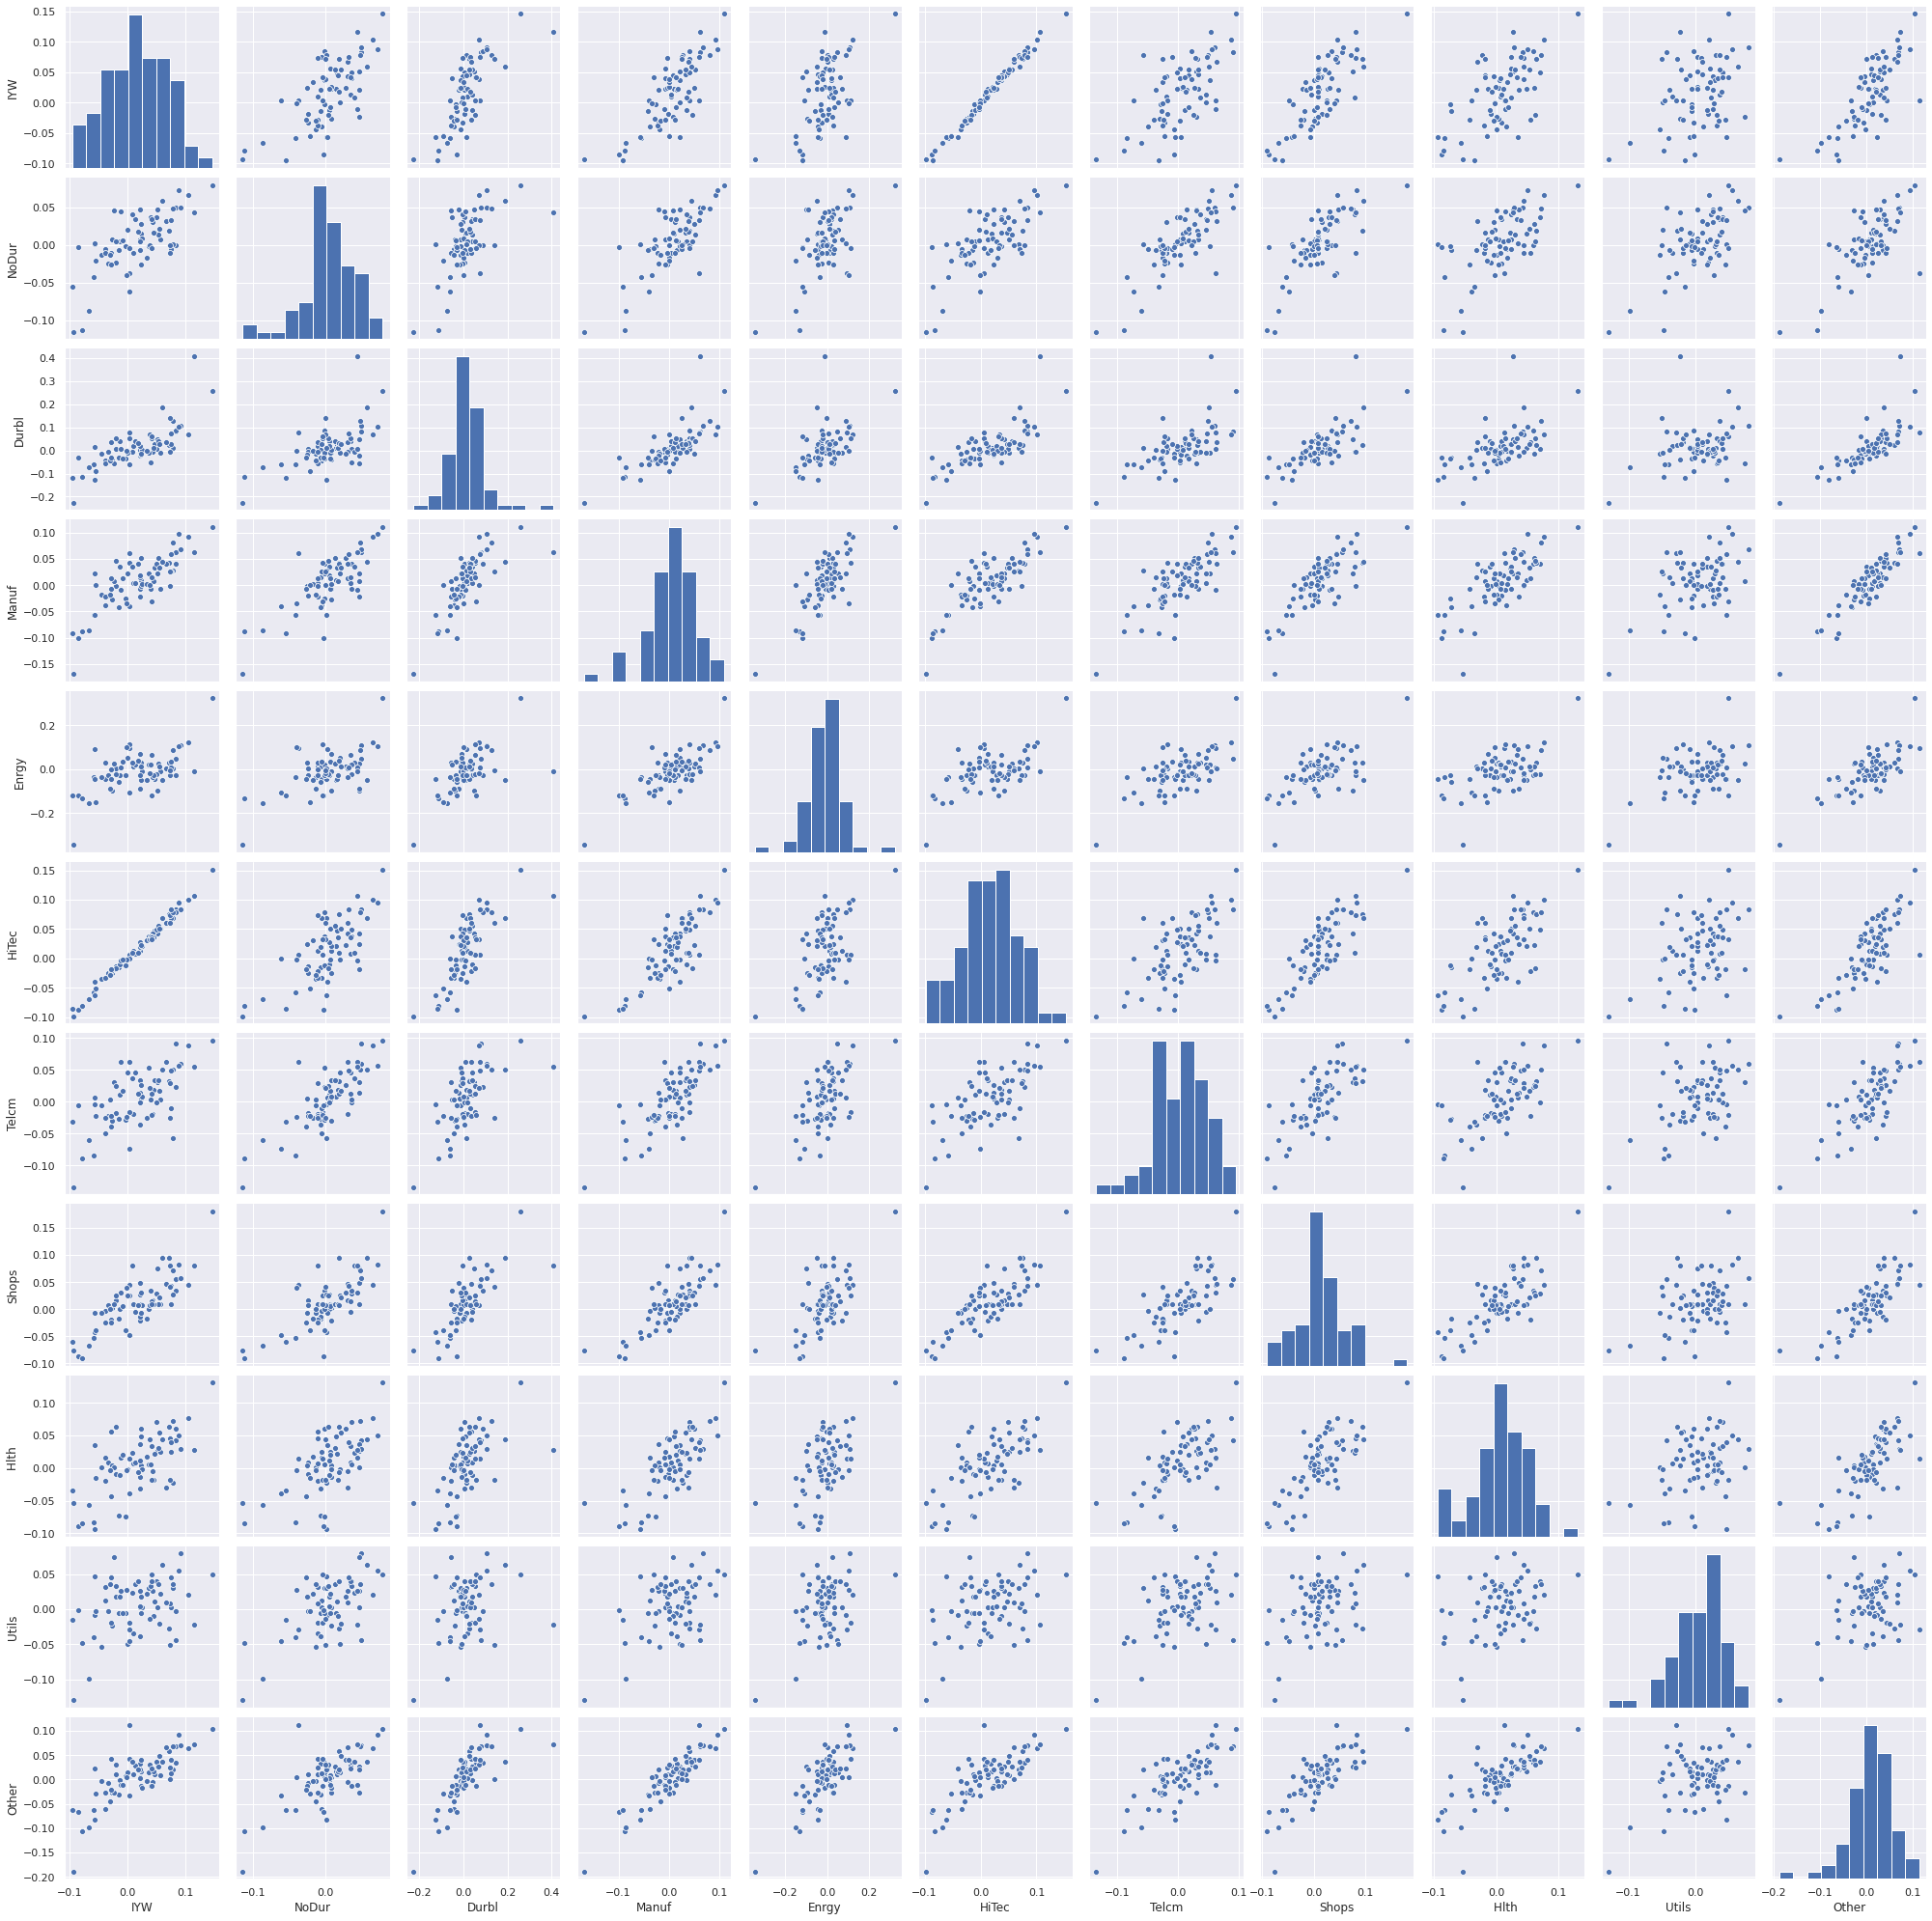

In [44]:
data = pd.concat([rets_monthly['IYW'], ind_data_10], axis=1).dropna()
plot_pairs(data, data.columns)

## Style Analysis on iShares U.S. Healthcare ETF

Observations:
1. Similar to Technology ETF, the fund returns are largely contributed by a single factor Hlth.  Highly likely that the equity holdings in this funds follows that of SIC: Hlth.
2. This is inline with the mandate of the ETF that to track an index composed of U.S. equities in the healthcare sector.
4. From the fund fact sheet, the fund has top sectors in Pharmaeuticals of 27.56%, follow by Health Care Equipment of 25.14%.

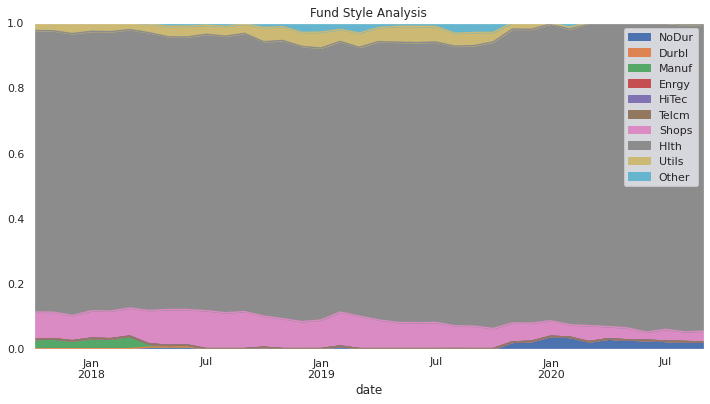

In [45]:
fund_name = 'IYH'
style_results = rolling_style_ind(fund_name, 36, 10)
style_results.set_index('date', inplace=True)

# We need to transform the data from raw data to percentage (fraction)
style_results_perc = style_results.divide(style_results.sum(axis=1), axis=0)

style_results_perc.plot(kind='area', stacked=True, figsize=(12,6), title='Fund Style Analysis', ylim=(0,1))
plt.show()

In [46]:
style_results_perc.iloc[-1].round(2).sort_values(ascending=False)*100

Hlth     94.0
Shops     3.0
NoDur     2.0
Other     0.0
Utils     0.0
Telcm     0.0
HiTec     0.0
Enrgy     0.0
Manuf     0.0
Durbl     0.0
Name: 2020-09, dtype: float64

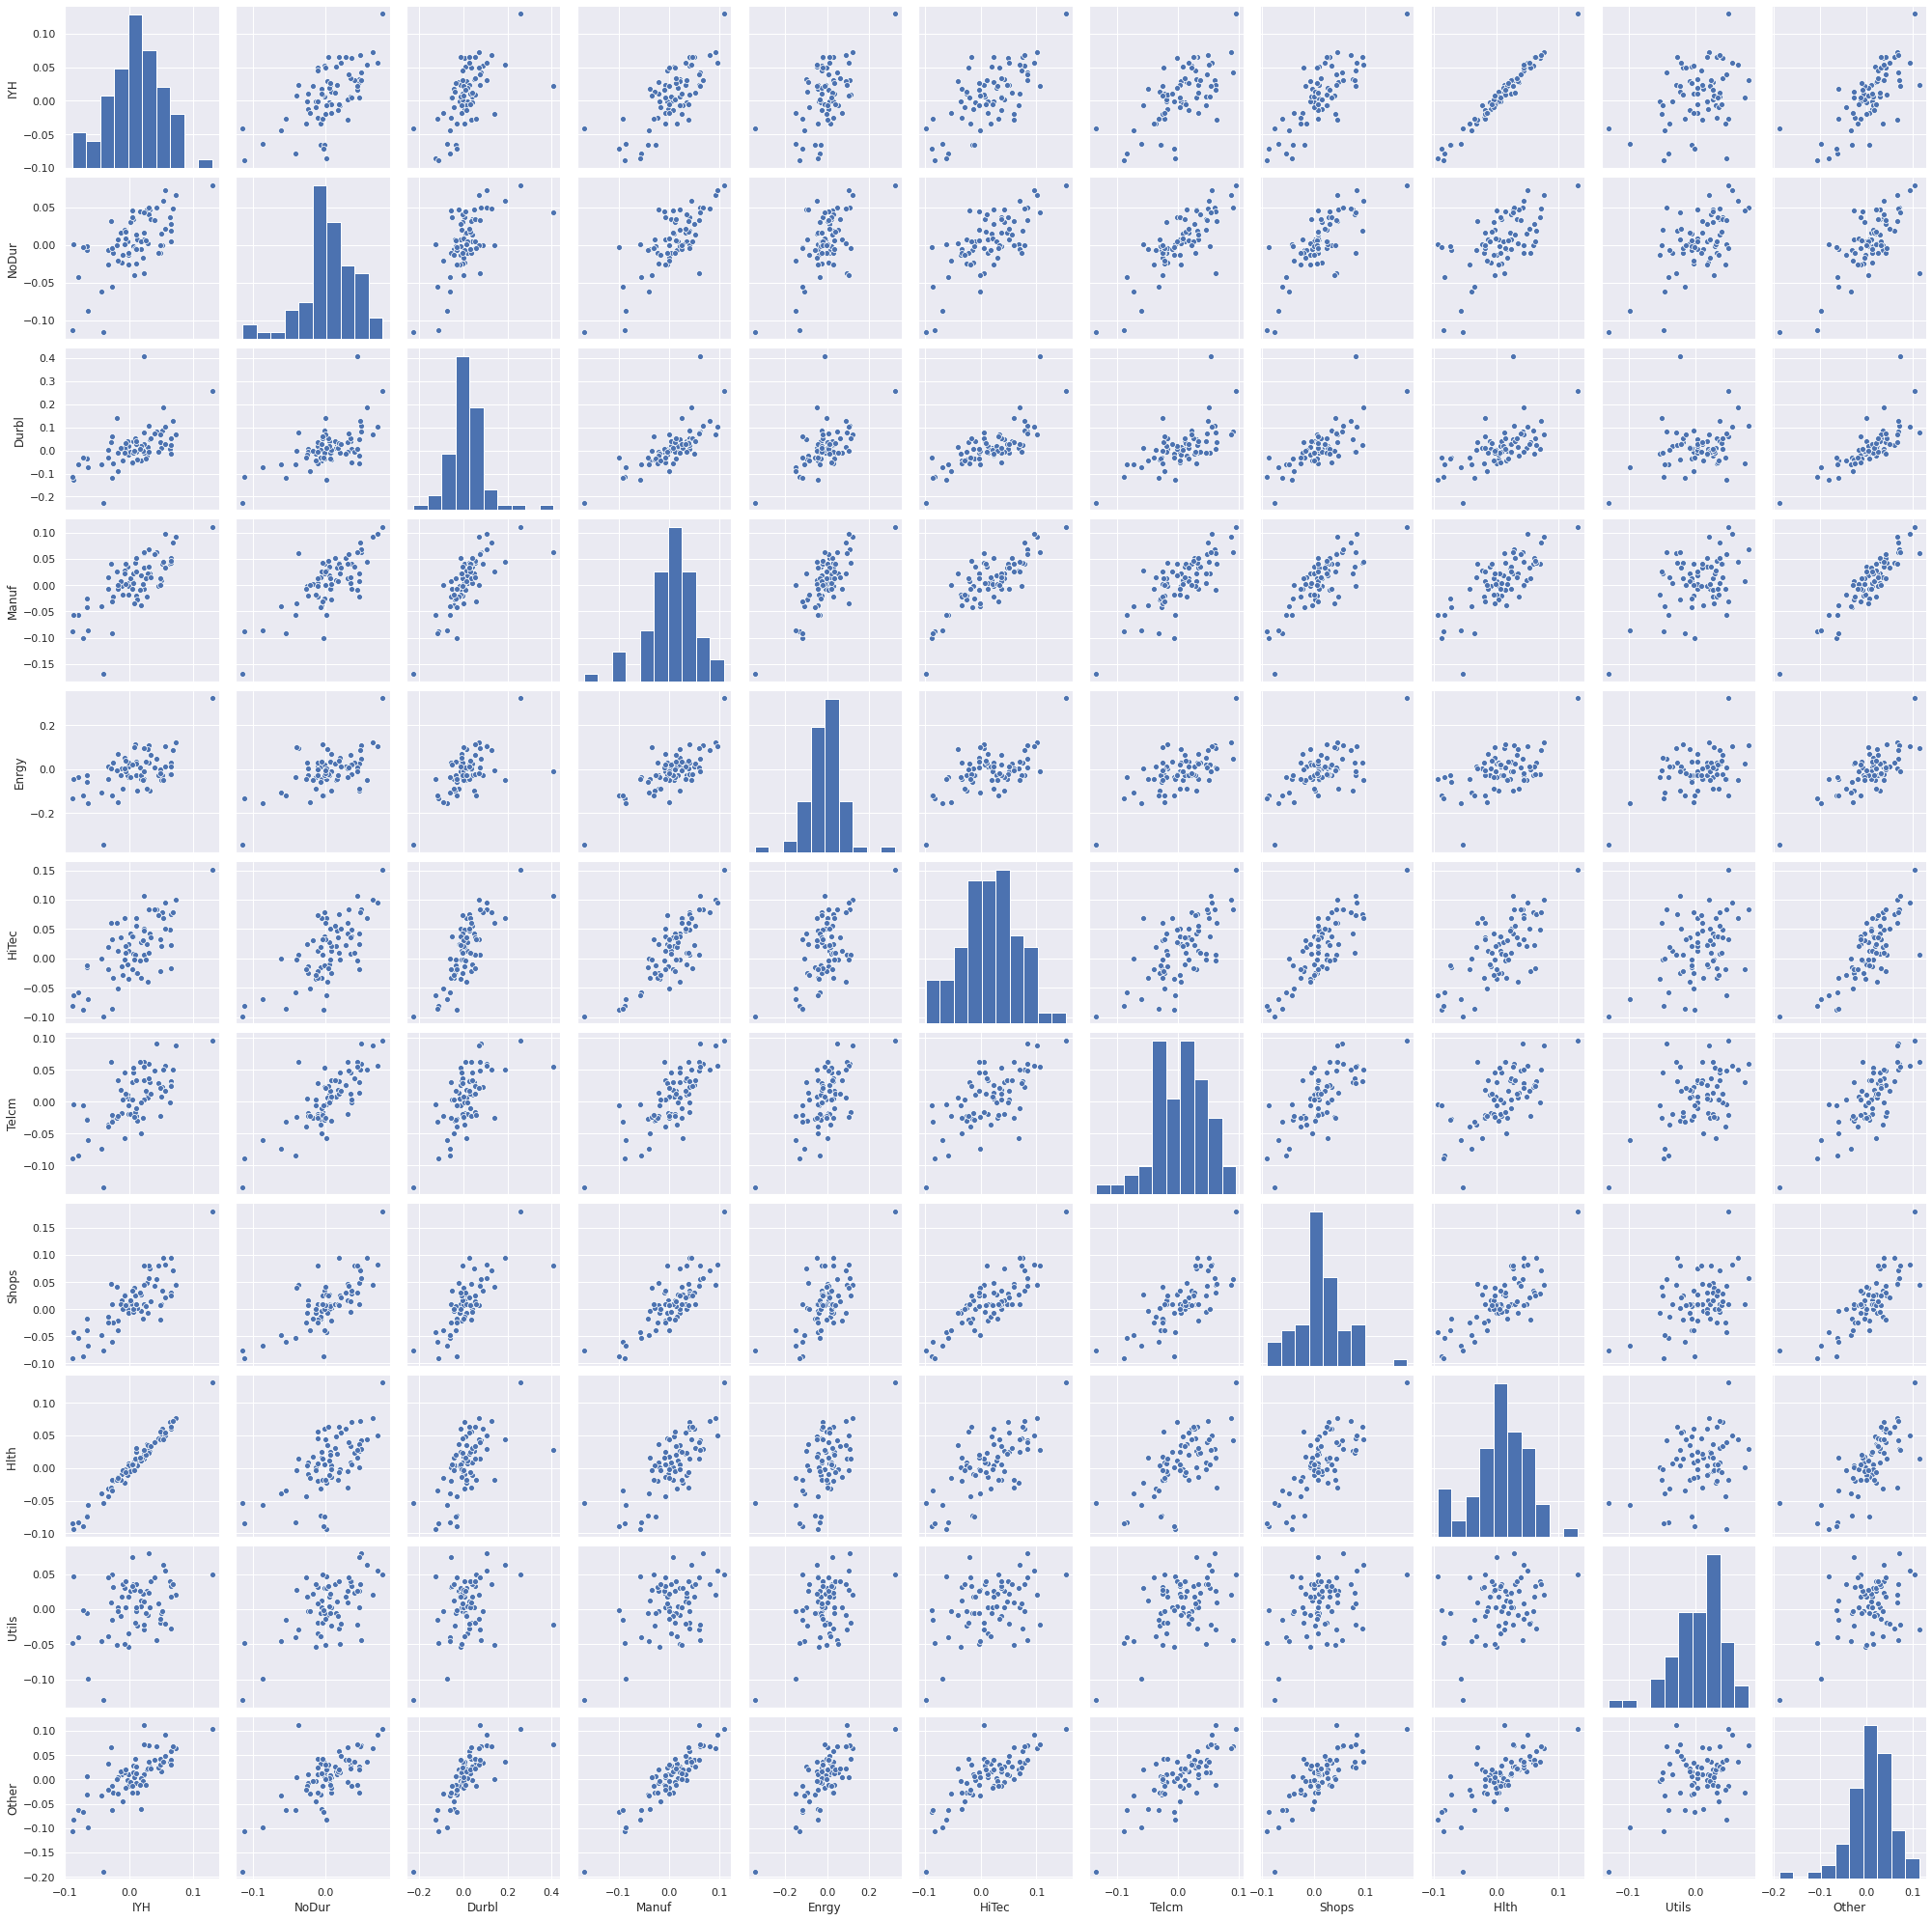

In [47]:
data = pd.concat([rets_monthly[fund_name], ind_data_10], axis=1).dropna()
plot_pairs(data, data.columns)

## Style Analysis on iShares U.S. Real Estate ETF

Observations:
1. The fund seems to have frequent changes in industry allocation over the years.  
2. This is inline with the mandate of the ETF that to track an index composed of U.S. equities in the US real estate.
3. From the fund fact sheet, the fund invests almost all in all kind of REITs including Residential, Industrial, Health Care, Retail, Office, Diverified, Hotel & Resort and Specialised.
4. The funds could be allocating to different kinds of REITs over the years depending on market outlook as shown on from the style analysis.  
5. Also, the 10 industries being used for this style analysis may not have been complete enough to explain the fund allocations reasonably.  Additional industries can be explored.
6. Utils, Telcm and Enrgy being the top largest factors could be due to investment in Specialised REITs and Industrial REITs that own data centres and infrastructure properties.

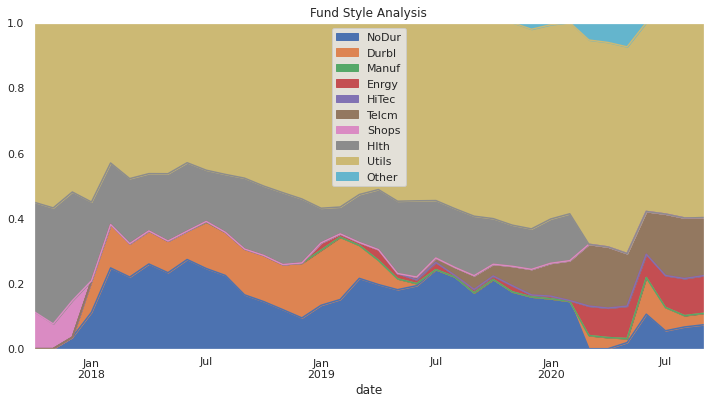

In [48]:
fund_name = 'IYR'
style_results = rolling_style_ind(fund_name, 36, 10)
style_results.set_index('date', inplace=True)

# We need to transform the data from raw data to percentage (fraction)
style_results_perc = style_results.divide(style_results.sum(axis=1), axis=0)

style_results_perc.plot(kind='area', stacked=True, figsize=(12,6), title='Fund Style Analysis', ylim=(0,1))
plt.show()

In [49]:
style_results_perc.iloc[-1].round(2).sort_values(ascending=False)*100

Utils    60.0
Telcm    18.0
Enrgy    12.0
NoDur     7.0
Durbl     4.0
Other     0.0
Hlth      0.0
Shops     0.0
HiTec     0.0
Manuf     0.0
Name: 2020-09, dtype: float64

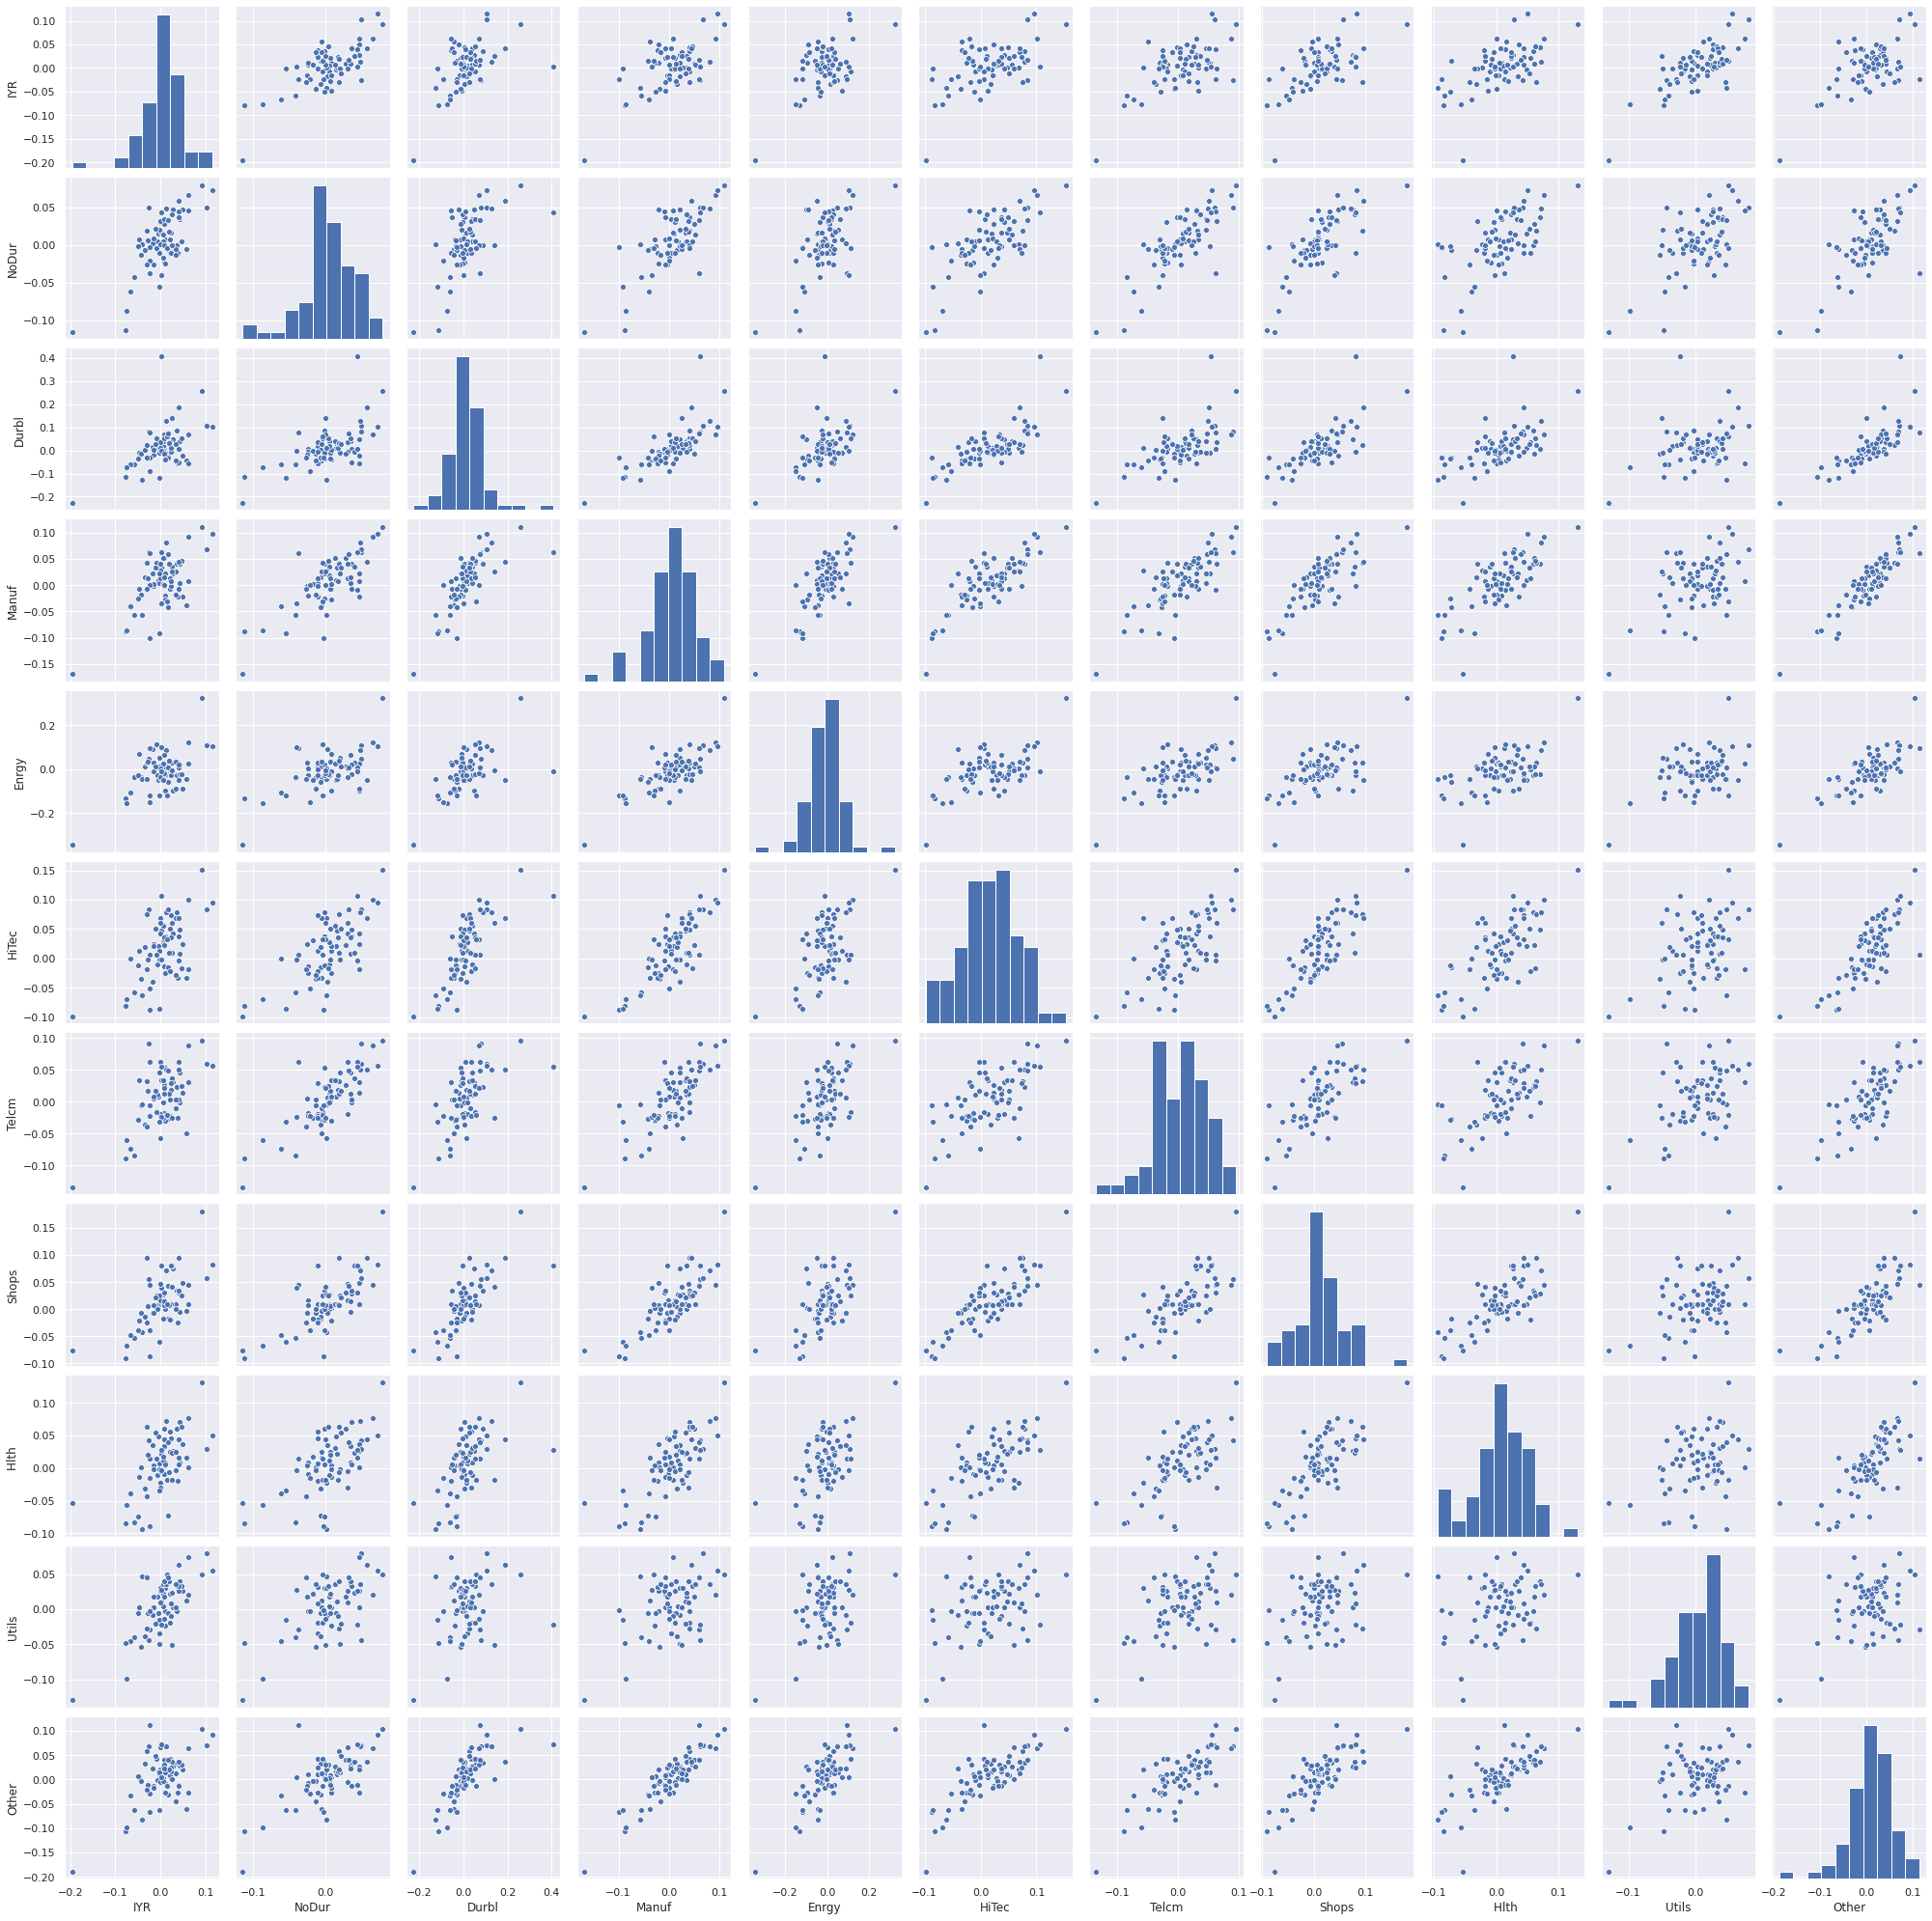

In [50]:
data = pd.concat([rets_monthly[fund_name], ind_data_10], axis=1).dropna()
plot_pairs(data, data.columns)

## Style Analysis on iShares U.S. Consumer Services ETF

Observations:
1. Fund returns are largely due to Shops factor contributing 52%.  Due to SIC classification, it is possible that other retail or consumer services related companies are classified under Others.
2. This is inline with the mandate of the ETF that to track an index composed of U.S. equities in the consumer services sector.
4. From the fund fact sheet, the fund has top sectors in Retailing of 40.93%, follow by Media and Entertainment of 22.64%.

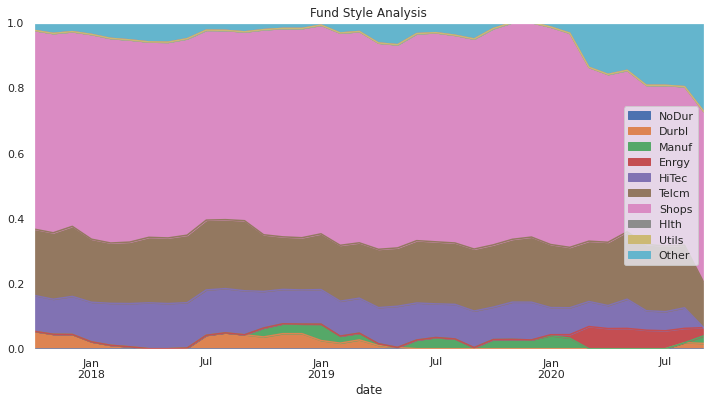

In [51]:
fund_name = 'IYC'
style_results = rolling_style_ind(fund_name, 36, 10)
style_results.set_index('date', inplace=True)

# We need to transform the data from raw data to percentage (fraction)
style_results_perc = style_results.divide(style_results.sum(axis=1), axis=0)

style_results_perc.plot(kind='area', stacked=True, figsize=(12,6), title='Fund Style Analysis', ylim=(0,1))
plt.show()

In [52]:
style_results_perc.iloc[-1].round(2).sort_values(ascending=False)*100

Shops    52.0
Other    27.0
Telcm    14.0
Enrgy     3.0
Manuf     2.0
Durbl     2.0
Utils     0.0
Hlth      0.0
HiTec     0.0
NoDur     0.0
Name: 2020-09, dtype: float64

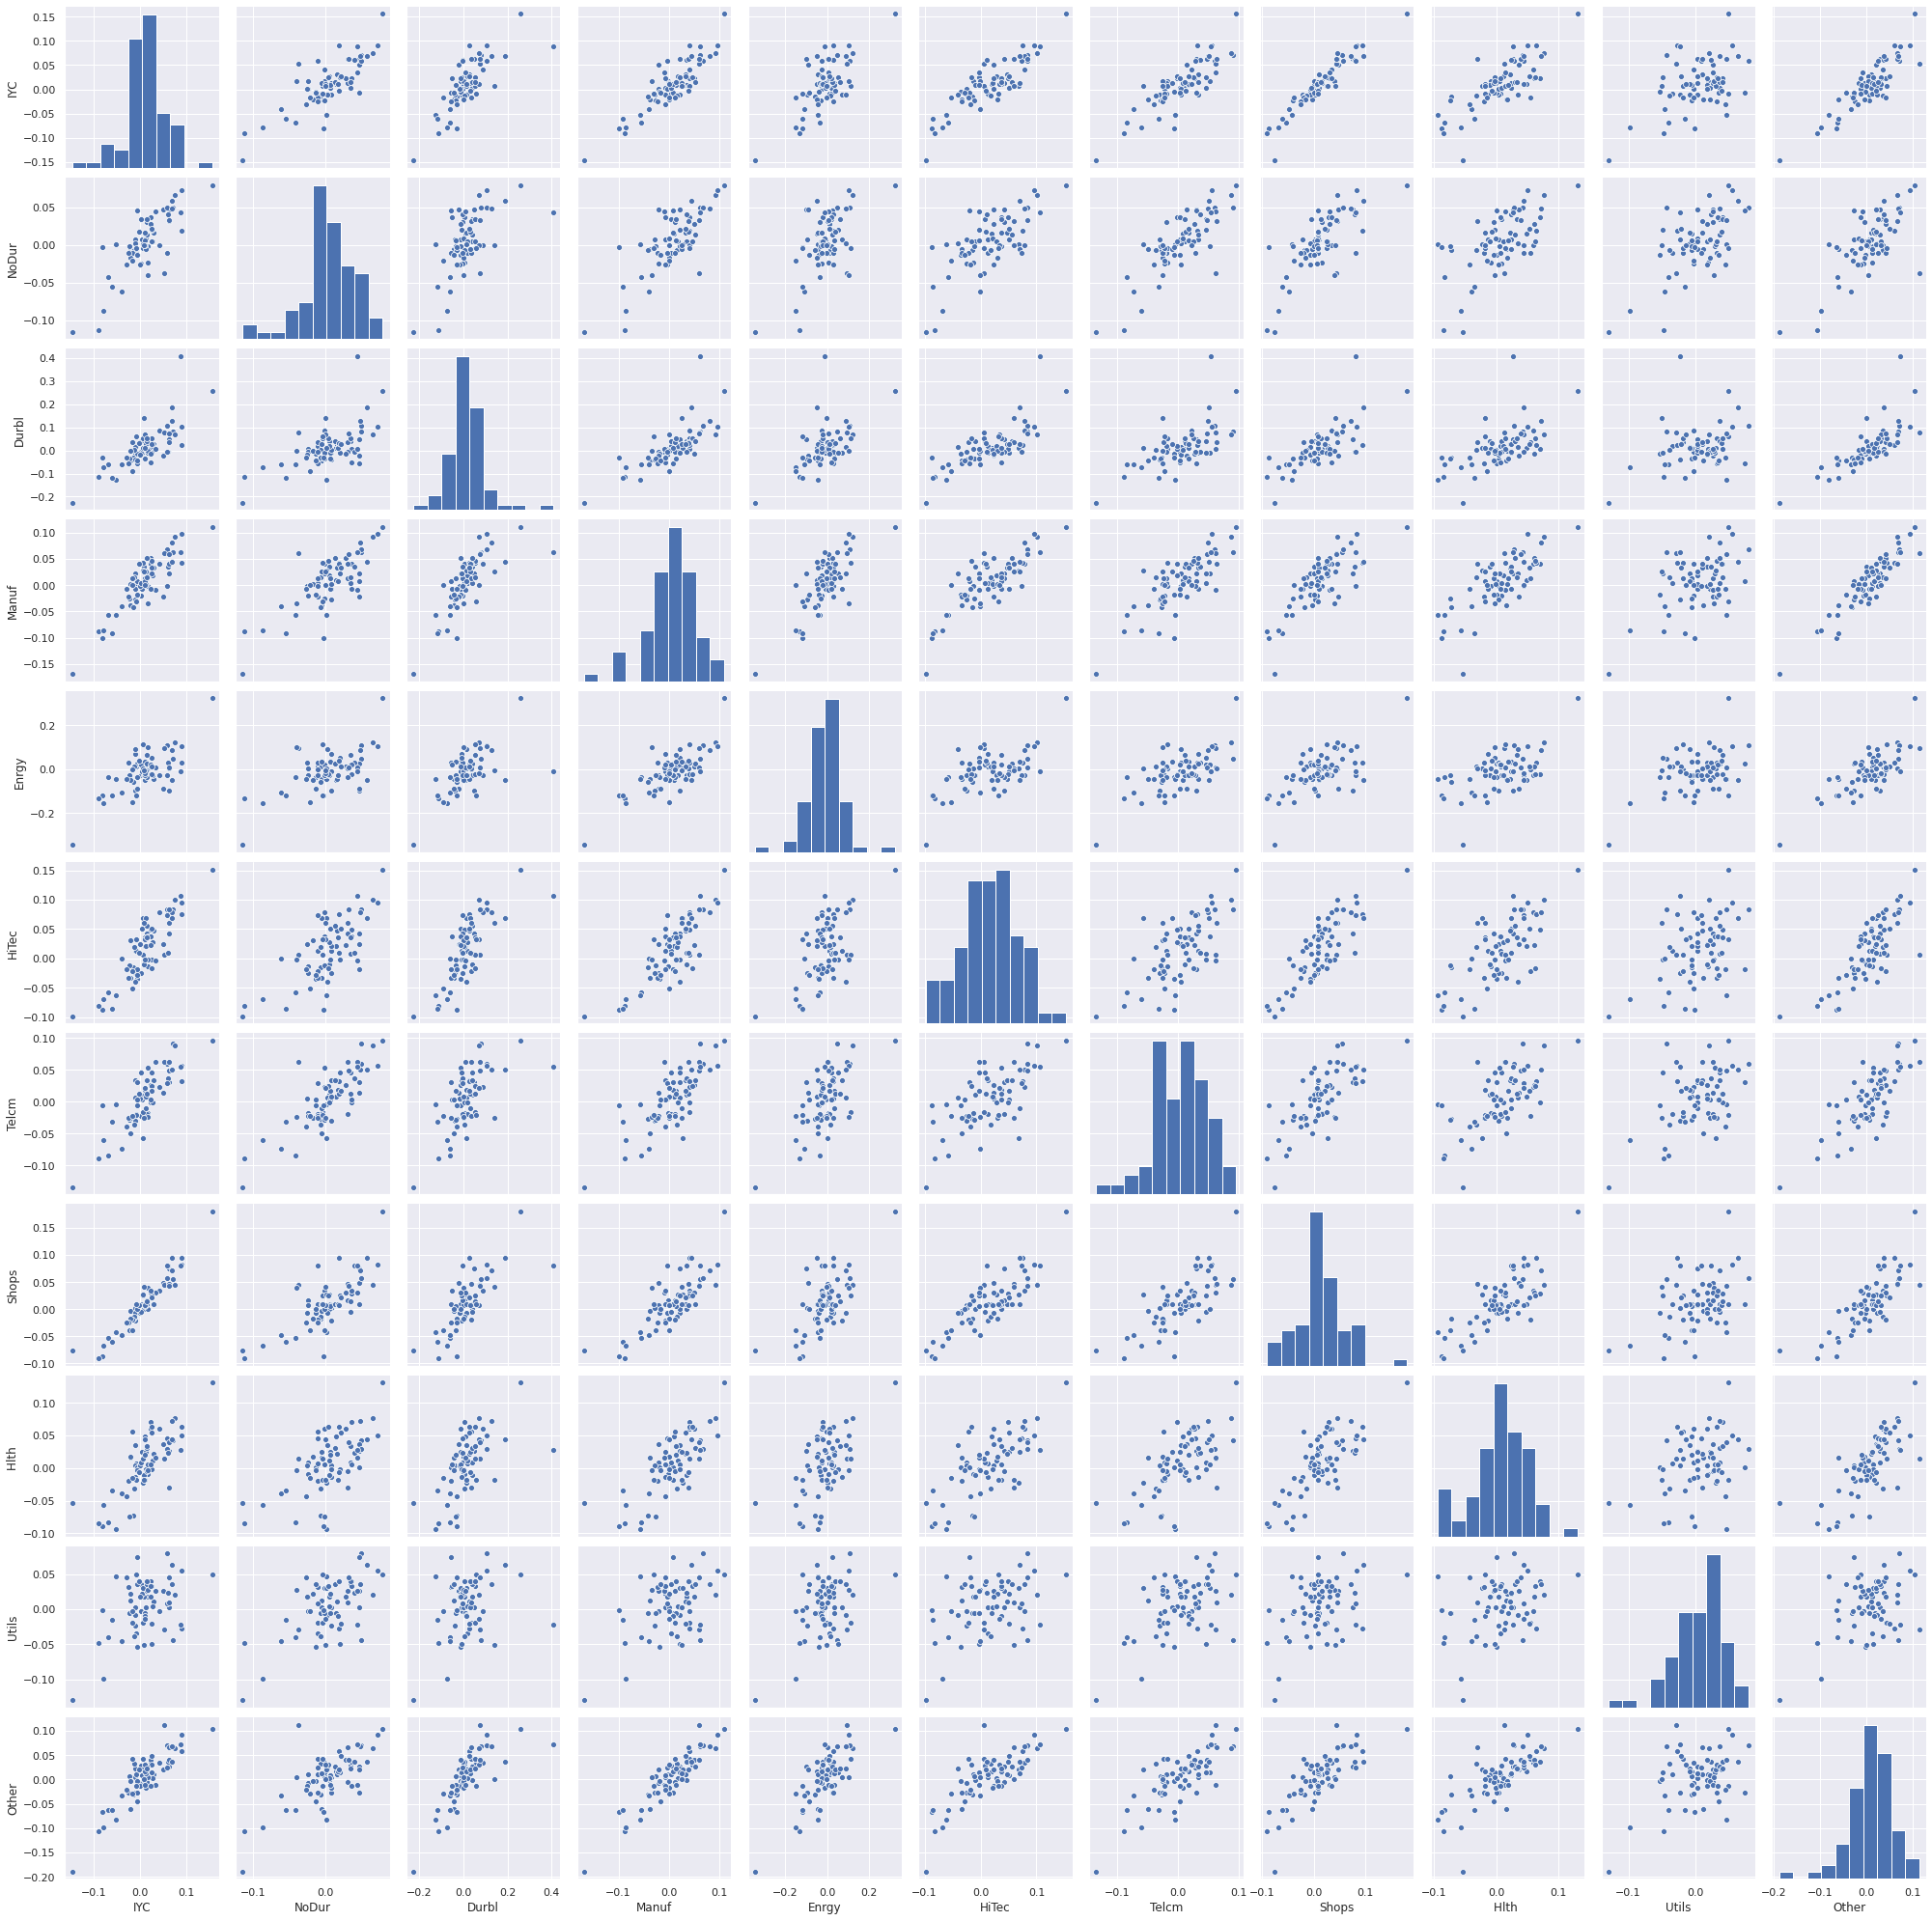

In [53]:
data = pd.concat([rets_monthly[fund_name], ind_data_10], axis=1).dropna()
plot_pairs(data, data.columns)

## Style Analysis on iShares Global Energy ETF

Observations:
1. Fund returns are largely due to Enrgy and Utils factors contributing 66% and 15% respectively
2. This is inline with the mandate of the ETF that to track an index composed of global equities in the energy sector.
3. From the fund fact sheet, the fund has top sectors in Integrated Oil and Gas of 55.96%, follow by Exploration & Production of 15.21% and Storage & Transportation of 15.05%.

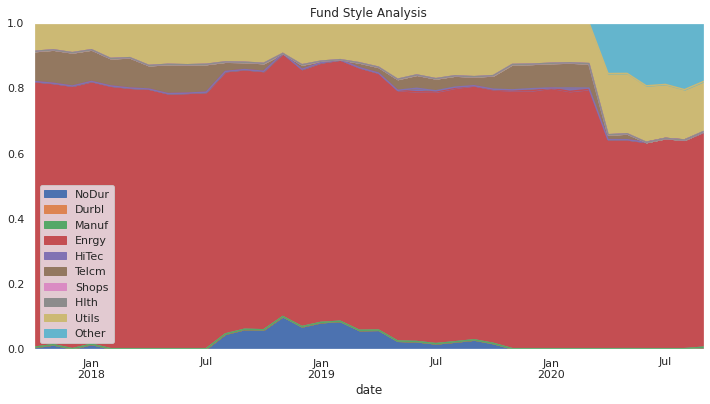

In [54]:
fund_name = 'IXC'
style_results = rolling_style_ind(fund_name, 36, 10)
style_results.set_index('date', inplace=True)

# We need to transform the data from raw data to percentage (fraction)
style_results_perc = style_results.divide(style_results.sum(axis=1), axis=0)

style_results_perc.plot(kind='area', stacked=True, figsize=(12,6), title='Fund Style Analysis', ylim=(0,1))
plt.show()

In [55]:
style_results_perc.iloc[-1].round(2).sort_values(ascending=False)*100

Enrgy    66.0
Other    18.0
Utils    15.0
Hlth      0.0
Shops     0.0
Telcm     0.0
HiTec     0.0
Manuf     0.0
Durbl     0.0
NoDur     0.0
Name: 2020-09, dtype: float64

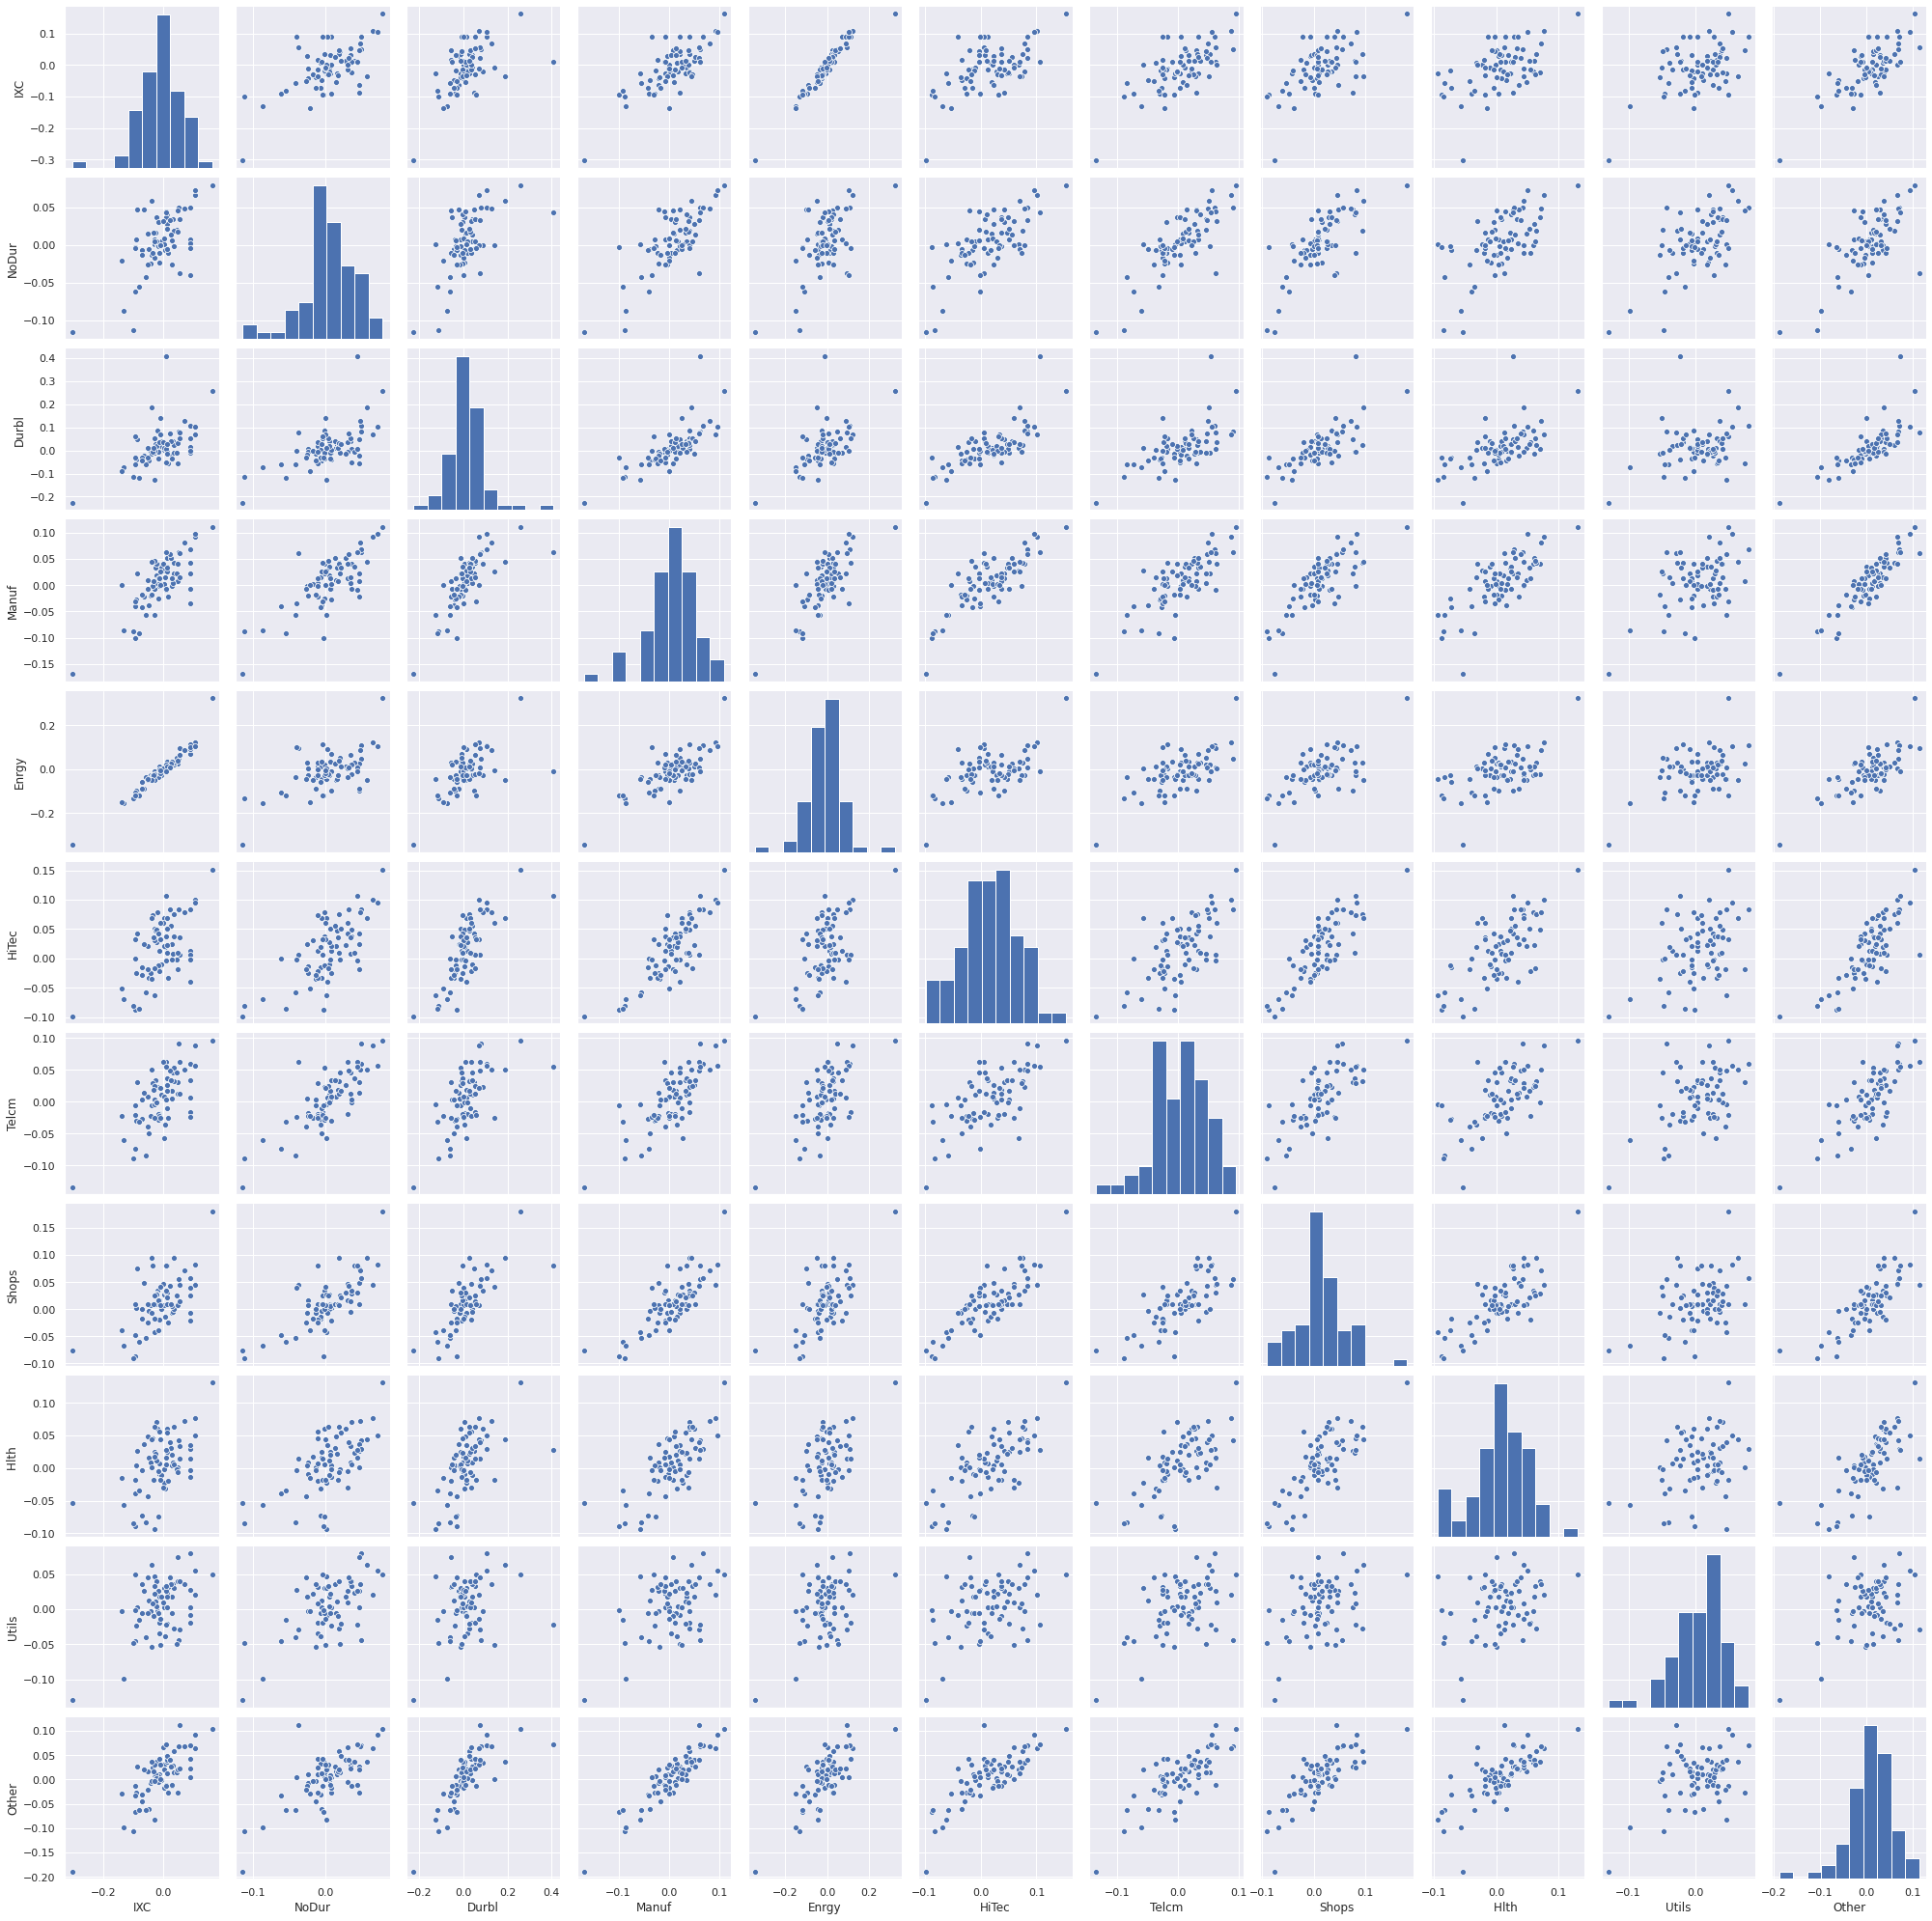

In [56]:
data = pd.concat([rets_monthly[fund_name], ind_data_10], axis=1).dropna()
plot_pairs(data, data.columns)

## Style Analysis on ARK INNOVATION ETF

Observations:
1. Fund returns are due to HiTec and Durbl factors only.  
2. This is inline with the mandate of the ETF that that seeks long-term growth of capital by investing under normal circumstances primarily (at least 65% of its assets) in domestic and foreign equity securities of companies that are relevant to the Fund’s investment theme of disruptive innovation.
3. The fund has around 10.36% invested in Tesla.  It is the fund top exposure and should be classified as Durbl.  Noticed the increase in exposure in Durbl from May 2019.  The fund could have started investing in Tesla then.

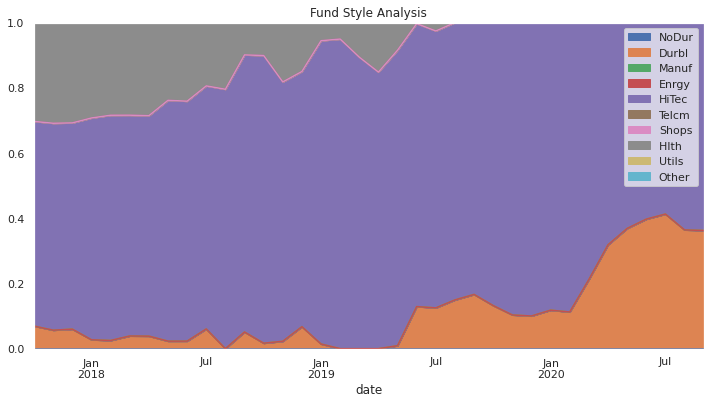

In [59]:
fund_name = 'ARKK'
style_results = rolling_style_ind(fund_name, 36, 10)
style_results.set_index('date', inplace=True)

# We need to transform the data from raw data to percentage (fraction)
style_results_perc = style_results.divide(style_results.sum(axis=1), axis=0)

style_results_perc.plot(kind='area', stacked=True, figsize=(12,6), title='Fund Style Analysis', ylim=(0,1))
plt.show()

In [60]:
style_results_perc.iloc[-1].round(2).sort_values(ascending=False)*100

HiTec    64.0
Durbl    36.0
Other     0.0
Utils     0.0
Hlth      0.0
Shops     0.0
Telcm     0.0
Enrgy     0.0
Manuf     0.0
NoDur     0.0
Name: 2020-09, dtype: float64

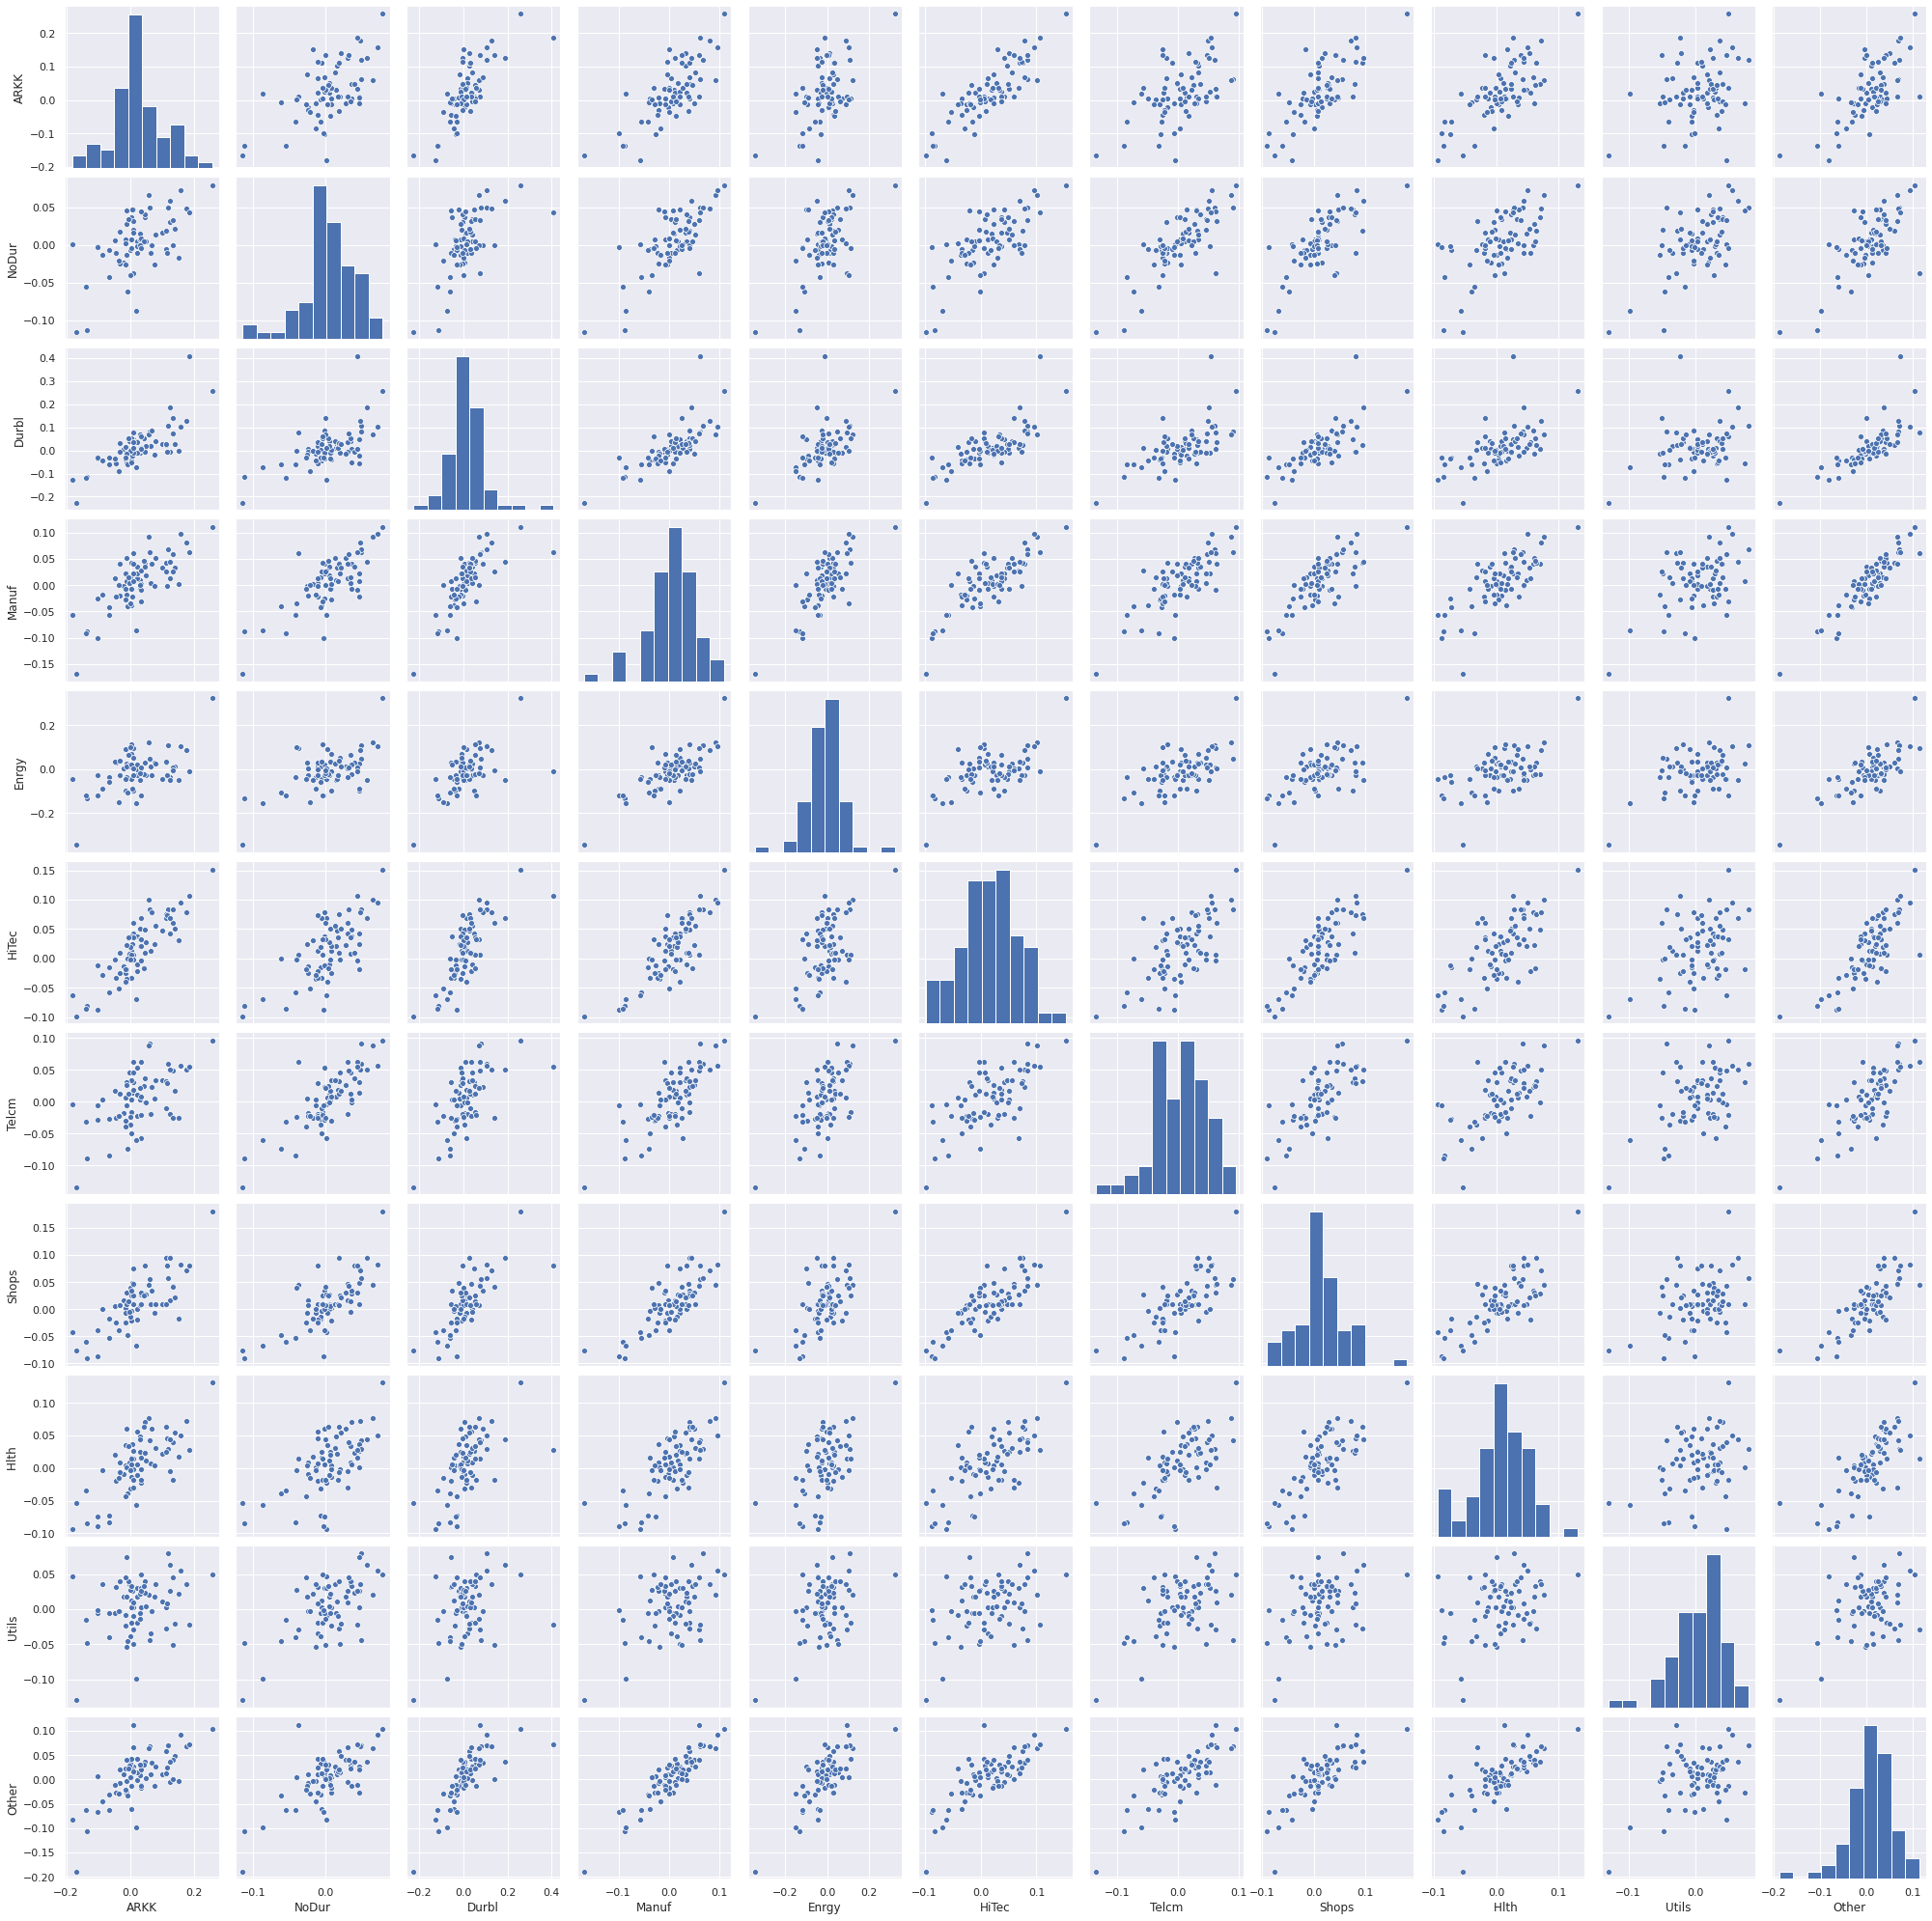

In [61]:
data = pd.concat([rets_monthly[fund_name], ind_data_10], axis=1).dropna()
plot_pairs(data, data.columns)